In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.regularizers import l1
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

1527/1527 [==============================] - 1s 735us/step
Joint X_train_normal and y_train_normal DataFrame:
       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      -0.152453        0.0  -0.615887        0.0  -0.618063  -0.152613   
1      -0.144326        0.0   0.368351        0.0   0.366181  -0.144338   
2      -0.144825        0.0   0.300472        0.0   0.299977  -0.144885   
3      -0.143178        0.0   0.493024        0.0   0.494129  -0.143055   
4      -0.152736        0.0  -0.638524        0.0  -0.641884  -0.152779   
...          ...        ...        ...        ...        ...        ...   
35161  -0.142656        0.0   0.562060        0.0   0.560656  -0.142639   
35162  -0.142978        0.0   0.521468        0.0   0.525599  -0.142872   
35163  -0.141039        0.0   0.748382        0.0   0.751153  -0.140911   
35164  -0.142618        0.0   0.559687        0.0   0.560659  -0.142624   
35165  -0.144847        0.0   0.293706        0.0   0.296392  -0.

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


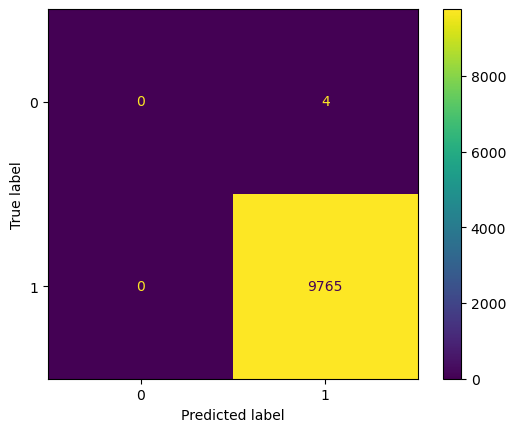

In [8]:


def hybrid_anomaly_detection():
    # Load data
#     data = pd.read_csv(filepath)
    
#     # Clean null values
#     data.dropna(inplace=True)
    
#     # Convert all variables to numerical values
#     for column in data.columns:
#         if data[column].dtype == 'object':
#             data[column] = data[column].astype('category').cat.codes
    
#     # Feature selection
#     X = data.drop('target', axis=1)  # Assuming 'target' is the column to predict
#     y = data['target']
#     selector = SelectKBest(f_classif, k='all').fit(X, y)
#     X_selected = selector.transform(X)
    
    
        # Load data from a CSV file   
    data = pd.read_csv('adultdata.csv')
    
    data.dropna(axis=0, inplace=True)
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 20000, 1, 0)  # Define `threshold` based on the dataset
    
    # Select top k features; k might be adjusted based on the dataset
#     selector = SelectKBest(f_classif, k=10)
#     X_selected = selector.fit_transform(X, y)
    
    #data.info()

    selector = SelectKBest(f_classif, k='all').fit(X, y)
    X_selected = selector.transform(X)
    
    
    
    
    # Sparse Autoencoder for dimensionality reduction
    input_layer = Input(shape=(X_selected.shape[1],))
    encoded = Dense(100, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
    decoded = Dense(X_selected.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0)
    X_reduced = encoder.predict(X_selected)
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Isolation Forest for detecting outliers
    iso_forest = IsolationForest(contamination=0.1)
    iso_forest.fit(X_train_scaled)
    isof_outcome = iso_forest.predict(X_train_scaled) == 1
    
    # Join normal data only
    X_train_normal = X_train_scaled[isof_outcome]
    y_train_normal = y_train[isof_outcome]
    
#     # Convert X_train_normal to DataFrame for better visibility
#     X_train_normal_df = pd.DataFrame(X_train_normal, columns=[f'feature_{i}' for i in range(X_train_normal.shape[1])])
#     print("X_train_normal DataFrame:")
#     print(X_train_normal_df)
    
#     # Join normal data only
#     X_train_normal = X_train_scaled[isof_outcome]
#     y_train_normal = y_train.iloc[isof_outcome]  # Ensure y_train_normal remains a pandas series
    
    
    # Combine X_train_normal and y_train_normal into a single DataFrame
    X_train_normal_df = pd.DataFrame(X_train_normal, columns=[f'feature_{i}' for i in range(X_train_normal.shape[1])])
    X_train_normal_df['fnlwgt'] = y_train_normal #.reset_index(drop=True)  # Reset index for correct alignment
    print("Joint X_train_normal and y_train_normal DataFrame:")
    print(X_train_normal_df)
    
    
    # Train XGBoost
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train_normal, y_train_normal)
    
    # Evaluate the model
    y_pred = xgb_model.predict(X_test_scaled)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {fscore}")
    
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# Usage example (specify the path to your data file)
hybrid_anomaly_detection()


1527/1527 [==============================] - 1s 880us/step
Joint X_train_normal and y_train_normal DataFrame:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.224642   0.089042   0.089493  -0.224293   0.089104  -0.032097   
1  -0.250849  -0.235386  -0.232420  -0.249090  -0.237369  -0.032097   
2  -0.211550   0.278807   0.259478  -0.211451   0.257609  -0.032097   
3  -0.274612  -0.527455  -0.528761  -0.271741  -0.534840  -0.032097   
4  -0.171870   0.752981   0.747988  -0.174026   0.750925  -0.032097   

   feature_6  feature_7  feature_8  feature_9  ...  feature_91  feature_92  \
0  -0.225063  -0.225160  -0.224520  -0.224647  ...    0.090944   -0.224497   
1  -0.252172  -0.253593  -0.250014  -0.250098  ...   -0.235606   -0.250536   
2  -0.208020  -0.211099  -0.210173  -0.210188  ...    0.281202   -0.211425   
3  -0.275910  -0.280023  -0.272982  -0.273009  ...   -0.523337   -0.274176   
4  -0.169569  -0.167439  -0.172690  -0.172634  ...    0.754356   -0.17228

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


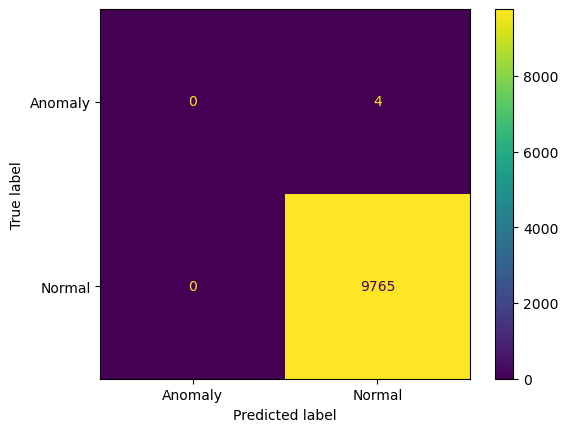

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.regularizers import l1
from xgboost import XGBClassifier

def hybrid_anomaly_detection():
    # Load data
    data = pd.read_csv('adultdata.csv')
    
    data.dropna(axis=0, inplace=True)
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 20000, 1, 0)  # Define `threshold` based on the dataset
    
    selector = SelectKBest(f_classif, k=10).fit(X, y)
    X_selected = selector.transform(X)
    
    # Sparse Autoencoder for dimensionality reduction
    input_layer = Input(shape=(X_selected.shape[1],))
    encoded = Dense(100, activation='relu', activity_regularizer=l1(10e-5))(input_layer)
    decoded = Dense(X_selected.shape[1], activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0)
    X_reduced = encoder.predict(X_selected)
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Isolation Forest for detecting outliers
    iso_forest = IsolationForest(contamination=0.1, n_estimators=200, random_state=42)
    iso_forest.fit(X_train_scaled)
    isof_outcome = iso_forest.predict(X_train_scaled) == 1
    
    # Join normal data only
    X_train_normal = X_train_scaled[isof_outcome]
    y_train_normal = y_train[isof_outcome]  # Direct indexing to maintain alignment
    
    # Combine X_train_normal and y_train_normal into a single DataFrame
    X_train_normal_df = pd.DataFrame(X_train_normal, columns=[f'feature_{i}' for i in range(X_train_normal.shape[1])])
    X_train_normal_df['fnlwgt'] = y_train_normal  # Add as a new column
    print("Joint X_train_normal and y_train_normal DataFrame:")
    print(X_train_normal_df.head())
    
    # Train XGBoost
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train_normal, y_train_normal)
    
    # Evaluate the model
    y_pred = xgb_model.predict(X_test_scaled)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {fscore}")
    
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


hybrid_anomaly_detection()
